In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from torchvision.datasets import FashionMNIST
from torch.utils.data import Subset, DataLoader
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Normal
import math
from torchvision import transforms
from torch.linalg import multi_dot
import gc
from PIL import Image

# Init



In [2]:

# Controlla la disponibilità della GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # Imposta il dispositivo sulla GPU
else:
    device = torch.device("cpu")  # Se la GPU non è disponibile, utilizza la CPU



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#ink originale: https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=drive_link&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ
#spostatelo nel vostro drive e copiatelo in locale (perchè il dataloader carica più velocemente le immagini leggendo da qui che dal vostro drive)
!cp '/content/drive/MyDrive/Generative_AI/datasets/celebA/img_align_celeba.zip' celebA.zip

In [11]:
import zipfile

with zipfile.ZipFile("celebA.zip", 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Esempio di forward diffusion process (schedule di diffusione lineare)

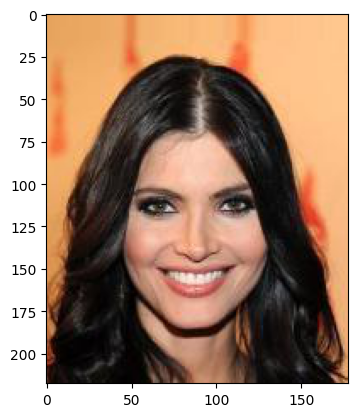

In [ ]:
#carico immagine di prova
img =  Image.open("/content/dataset/img_align_celeba/148990.jpg")
plt.imshow(img)

Esempio di applicazione rumore

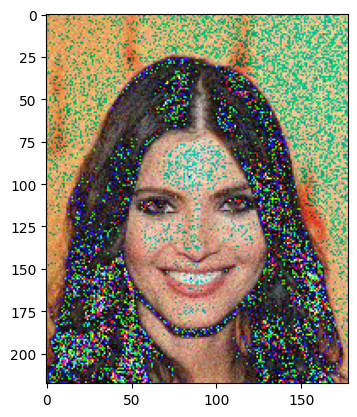

In [ ]:
img_mat = torch.tensor(np.array(img), dtype=torch.float32)

beta = torch.tensor(0.02, dtype=torch.float32)

#normalizzo l'immagine affinchè abbia media 0 e varianza 1
transform = transforms.Compose([
    transforms.ToTensor(),  # Converte l'immagine in un tensore (normalizza automaticamente tra 0 e 1)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizza i valori dei pixel tra -1 e 1 con varianza 1
])

img_mat = transform(img)

#applico la trasformazione sqrt(1-beta)*x + sqrt(beta)*eps
img_mat2 = torch.sqrt(1.-beta)*img_mat + torch.sqrt(beta)*torch.randn_like(img_mat)

inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]),  # Riporta i valori dei pixel tra -1 e 1 a 0 e 1
    transforms.ToPILImage(),  # Converte il tensore in un oggetto immagine PIL
])

plt.imshow(inverse_transform(img_mat2))

Esempio di forward diffusion process con schedule di diffusione lineare

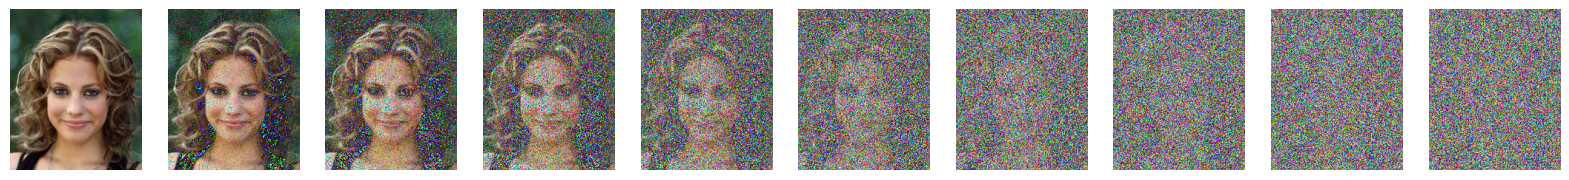

In [ ]:
img =  Image.open("/content/dataset/img_align_celeba/178990.jpg")
img_mat = torch.tensor(np.array(img), dtype=torch.float32)

num_steps=1000
beta = torch.linspace(0.0001, 0.002, num_steps)

#normalizzo l'immagine affinchè abbia media 0 e varianza 1
transform = transforms.Compose([
    transforms.ToTensor(),  # Converte l'immagine in un tensore (normalizza automaticamente tra 0 e 1)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizza i valori dei pixel tra -1 e 1 con varianza 1
])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]),  # Riporta i valori dei pixel tra -1 e 1 a 0 e 1
    transforms.ToPILImage(),  # Converte il tensore in un oggetto immagine PIL
])

img_mat = transform(img)

images = [img]
for i in np.arange(num_steps):
  img_i = torch.sqrt(1.-beta[i])*img_mat + torch.sqrt(beta[i])*torch.randn_like(img_mat)
  images.append(inverse_transform(img_i))
  img_mat = img_i

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 4))

# Itera attraverso le immagini e le assegna a ciascun subplot
i_valid = np.int32(np.linspace(0,num_steps,10))
for i, ax in enumerate(axes):
    ax.imshow(images[i_valid[i]])
    ax.axis('off')  # Rimuovi i valori degli assi x e y

# Mostra il grafico
plt.show()


# Model

In [4]:

class DDGM(nn.Module):

  def __init__(self, input_shape_image, num_steps, hidden_neurons):
    super(DDGM, self).__init__()

    self.input_shape_image = input_shape_image

    self.num_steps = num_steps

    self.beta = torch.linspace(0.0001,0.02, num_steps).to(device)

    #creo le reti neurali che parametrizzeranno ogni p(zi| z_i+1)
    self.p_nets = torch.nn.ModuleList([nn.Sequential(
                                                    nn.Linear(1*input_shape_image, hidden_neurons),
                                                    nn.BatchNorm1d(hidden_neurons),
                                                    nn.LeakyReLU(),
                                                    nn.Linear(hidden_neurons, 2*hidden_neurons),
                                                    nn.BatchNorm1d(2*hidden_neurons),
                                                    nn.LeakyReLU(),
                                                    nn.Linear(2*hidden_neurons, 3*hidden_neurons),
                                                    nn.BatchNorm1d(3*hidden_neurons),
                                                    nn.LeakyReLU(),
                                                    nn.Linear(3*hidden_neurons, 2*(1*input_shape_image)),
                                                  ) for _ in range(self.num_steps-1)])

    #creo la rete per decodificare, ossia p(x|z1)
    self.decoder = nn.Sequential(
                         nn.Linear(1*input_shape_image, hidden_neurons),
                         nn.BatchNorm1d(hidden_neurons),
                         nn.LeakyReLU(),
                         nn.Linear(hidden_neurons, 2*hidden_neurons),
                         nn.BatchNorm1d(2*hidden_neurons),
                         nn.LeakyReLU(),
                         nn.Linear(2*hidden_neurons, 3*hidden_neurons),
                         nn.BatchNorm1d(3*hidden_neurons),
                         nn.LeakyReLU(),
                         nn.Linear(3*hidden_neurons, (1*input_shape_image)),
                         #Tanh è di vitale importanza in quanto predico dati tra -1 e 1 dato
                         #che sono normalizzati tra -1 e 1
                         nn.Tanh()
    )


  '''
      Questa funziona ritorna il log prob di una distribuzione normale a covarianza
      diagonale.
                       p(x┤μ,Σ)=1/((2π)^(1/n)∙√(|Σ|)) e^((-1/2 (x-μ)^T∙Σ^(-1) (x-μ)) )
      Data la forma chiusa risulta più veloce della MultivariateNormal in quanto
      evito di calcolare:
      1) l'inversa. Infatti l'inversa di una matrice diagonale è una matrice diagonale con la diagonale
         uguale all'inverso di quella della matrice originale.
      2) determinante. Essendo la covarianza diagonale il determinante risulta essere il prodotto degli elementi in diagonale

      NB: per evitare overflow (errore 34) calcolo il log prob di p() come:
                    log(p)=-0.5(n∙ln(2π)+ln(|Σ|)+(z-μ)^T∙Σ^(-1) (z-μ))
  '''
  def normal_log_prob(self, mean, log_var, x):

    return  -0.5*((self.input_shape_image*1)*torch.log(torch.tensor(2*torch.pi)) + (torch.sum(torch.log(torch.exp(log_var)),-1)) + torch.matmul((x-mean).unsqueeze(1),torch.transpose(torch.matmul(torch.diag_embed(1/torch.exp(log_var)),(x-mean).unsqueeze(2)).squeeze(2).unsqueeze(1),1,2)).squeeze(2).squeeze(1))

  def sample(self):

    #adesso inietto z dal basso verso l'alto fino ad arrivare a z1
    z = torch.zeros(1*self.input_shape_image).to(device)

    for i in np.arange(self.num_steps-1,-1,-1):
      if i==self.num_steps-1:
        #campiono da p(zT)=N(0,I)
        p = MultivariateNormal(torch.zeros(1*self.input_shape_image).to(device), torch.eye(1*self.input_shape_image).to(device))
        z = p.sample()
        z = z.unsqueeze(0)
      else:
        output = self.p_nets[i](z)
        mean,log_var = torch.chunk(output, 2,dim=-1)
        z = MultivariateNormal(mean, torch.diag_embed( torch.exp(log_var))).sample()

    #l'ultimo z è z1, lo uso nel decoder per predirre x
    x = self.decoder(z)

    return x



  '''
      Beta è un vettore [b1,b2,....,bt] contenente valori di beta
      che da 0.0001 incrementano linearmente fino a 0.02 in T passi e
      rappresentano la quantità di rumore da applicare (da poco a tanto).
      Li utilizzo per calcolare le trasformazioni di ogni immagine. Per esempio
      allo step i calcolo x_(i+1) come:

        x_(i+1) = √(1-b_i)*x_i + √b_i*eps  con eps~N(0,I)

      Ciascuna trasformazione equivale a una variabile latente nel concetto
      degli Hierarchical VAE.

  '''
  def forward_diffusion_process(self,x):
      #print("FORWARD DIFFUSION PROCESS_____________________________")
      #creo un tensore (N, num_steps, W, H) contenente per ognuna delle N immagini
      #tutte le num_steps trasformazioni
      zs = torch.zeros((x.shape[0],self.num_steps, x.shape[1], x.shape[2]), dtype=torch.float32).to(device)

      #calcolo la prima trasformazione
      #creo (W,H) eps, uno per ogni pixel di ogni canale
      eps = torch.randn_like(x).to(device)
      zs[:,0,:,:] = torch.sqrt(1.-self.beta[0])*x + torch.sqrt(self.beta[0])*eps

      #adesso procedo con le rimanenti T-1 trasformazioni
      for i in np.arange(1,self.num_steps):
        eps = torch.randn_like(x).to(device)
        zs_i = torch.sqrt(1.-self.beta[i])*zs[:,(i-1),:,:]+ torch.sqrt(self.beta[i])*eps
        zs[:,i,:,:]=zs_i

      return zs

  #questa funzione semplicemente ritorna la probabilità che N(v_predicted,I) ha su v_true
  def p_log_prob(self, x_predicted, x_true):
    '''
    Se la varianza è fissa a I, allora:
      log⁡(p(x_ij ))=log⁡(1/(1√2π) e^(-1/2∙(x_ij-μ)^2/1) )
                   =log⁡(1/(1√2π))+log⁡(e^(-1/2∙(x_ij-μ)^2/1) )
                   ==log⁡(1/(1√2π))-1/2∙(x_ij-μ)^2
    '''
    return torch.log(1/(torch.sqrt(torch.tensor(2)*torch.pi))) - 0.5*(x_true-x_predicted)**2

  def forward(self, x):
    #in ingresso ho immagini (N, M, M) già normalizzati per avere media 0 e varianza 1

    #applico il FORWARD DIFFUSION PROCESS______________________________________
    zs = self.forward_diffusion_process(x)

    #applico il REVERSE DIFFUSION PROCESS______________________________________
    '''
        Ho scomposto le prior in:
                p(x,z)=p(x│z)p(z)=p(x│z_1 )p(z_1│z_2 )…p(z_(T-1)│z_T )p(z_T )
        Questo significa che ogni prior dipende solo dallo z precedente
        Ogni prior sarà quindi parametrizzata da una rete neurale che ha in ingresso
        solo lo z precedente. Ogni rete neurale parametrizza una distribuzione gaussiana
        con media mu e varianza log_var
    '''

    #per ogni layer, da quello più alto (p(z2|z1)) al penultimo più basso (p(z_(t-1)|z_t))...
    KL = torch.zeros(zs.shape[0]).to(device)

    #print("REVERSE_________________________________")
    index_for_beta = 0
    for i in np.arange(self.num_steps-1,-1,-1):# i=T-1, T-2, T-3,....,0

        #se sono alla fine...(ossia primo ciclo del for)
        if i==self.num_steps-1:
          '''
              Significa che devo prendere zT e valutare:
              1) ln(q(z_T| z_(T-1)) con q=N(√(1-b)*z_(T-1), √(b)*I)
              2) ln(p(z_T)) dove p(z_T)=N(0,I)

              Ottenuti questi, calcolo la prima KL divergence:
                      KL_1 = E[ln(q(z_T| z_(T-1)) - ln((p(z_T))) ]
          '''
          #(N,W,H)
          z_T = zs[:,i,:,:].flatten(start_dim=1,end_dim=2) # z_T
          z_T_m_1 = zs[:,i-1,:,:].flatten(start_dim=1,end_dim=2) #z_(T-1)
          #calcolo ln(q(z_T| z_(T-1))
          mean = torch.sqrt(1-self.beta[i])*z_T_m_1
          log_var = torch.log((self.beta[i])*torch.ones((zs.shape[0],1*input_shape_image)).to(device))#print("var",var)
          ln_q = self.normal_log_prob(mean, log_var, z_T ).to(device)

          #calcolo ln(p(z_T))
          ln_p = self.normal_log_prob(torch.zeros(1*input_shape_image).to(device), torch.zeros(1*input_shape_image).to(device),z_T ).to(device)

          KL = ln_q - ln_p

        #altrimenti...
        else:
          '''
              Significa che devo fare la stessa cosa, solo che cambia il punto 2:

              2)ln(p(z_i|z_(i+1))) dove p(z_i|z_(i+1))=N(u,var)
                dove:
                      [u,var] = NeuralNetwork(z_(i+1))   (sarebbe p_net)

              Quindi poi calcolo:
                      KL_i = E[ln(q(z_i| z_(i-1)) - ln((p(z_i|z_(i+1)))) ]
          '''
          z_i = zs[:,i,:,:].flatten(start_dim=1,end_dim=2) # z_i
          z_i_p_1 = zs[:,i+1,:,:].flatten(start_dim=1,end_dim=2) # z_(i+1)
          z_i_m_1 = zs[:,i-1,:,:].flatten(start_dim=1,end_dim=2) # z_(i-1)
          if i==0:
            z_i_m_1 = x.flatten(start_dim=1,end_dim=2)

          #calcolo ln(q(z_i| z_(i-1))
          mean = torch.sqrt(1-self.beta[i])*z_i_m_1
          var = (self.beta[i])*torch.ones(1*input_shape_image).to(device)

          ln_q = self.normal_log_prob(mean, torch.log(var),z_i ).to(device)

          #calcolo ln((p(z_i|z_(i+1))))
          output = self.p_nets[i](z_i_p_1)
          mean, log_var = torch.chunk(output,2,dim=-1)

          ln_p = self.normal_log_prob(mean, log_var,z_i ).to(device)

          KL = KL + (ln_q-ln_p)


    #adesso decodifico l'ultima latent variable, ossia p(x|z1), per calcolare ln(p(x|z1)) (RE)
    x_predicted = self.decoder(zs[:,0,:,:].flatten(start_dim=1, end_dim=2))

    '''
        Immaginiamo che l'immagine x abbia per il pixel (i,j) il true value di v_true.
        Allora nel vettore x_predicted, nella cella (i,j) (anche se è flattato in un unico vettore, canali compresi),
        prendo il valore predetto v_predicted e lo considero la media di una distribuzione a varianza I. Per valutare
        quanto buona è la predizione calcolo il log della probabilità di v_true su quella distribuzione.
        Nota che questo è come se facessimo const - MSE(v_true,v_predicted)
    '''

    log_prob_x_predicted = self.p_log_prob(x_predicted,x.flatten(start_dim=1, end_dim=2))

    #La MLE per ogni immagine è la solita, la somma dei logaritmi delle probabilità
    #Questa coinciderà con il Reconstruction Error ln(p(x|z1))
    RE = log_prob_x_predicted.sum(-1)


    #ritorno ELBO
    return -(RE-KL).mean()



# Main

In [ ]:
##################################### GPU (info) + Path ##########################################

print("Device utilizzato:", device)
print("Numero di GPU disponibili:", torch.cuda.device_count())


#path dove salvare il modello migliore e i vari output di ogni epoca valida
path_to_model = "/content/drive/MyDrive/Generative_AI/datasets/celebA/model/model_DDGM_25_step_200.pth"
path_to_output = "/content/drive/MyDrive/Generative_AI/datasets/celebA/output/DDGM_25_step_200_"





##################################### Dataloader ##########################################

#per motivi di efficienza, scegliere il rescaling e il massimo valore che ogni pixel può assumere
resize_to = 25
max_pixel_value = 255

input_shape_image = resize_to*resize_to
possible_pixel_values = max_pixel_value+1


def load_data():

    def normalize_and_dequantize(image):

      image = np.clip(np.array(image)+np.random.normal(0, 0.4, size=(image.size)),0,255)

      image = 2. * (np.array(image) / 255.) - 1.

      return image

    # Definisci le trasformazioni da applicare alle immagini durante il caricamento
    transform = transforms.Compose([
        transforms.Resize( (resize_to, resize_to) ), #rescaling di ogni immagine
        transforms.Grayscale(),
        normalize_and_dequantize,
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.to(torch.float32)),
    ])

    # Crea un oggetto ImageFolder per caricare le immagini dalla cartella specificata e applica le trasformazioni definite
    dataset = datasets.ImageFolder('/content/dataset/', transform=transform)

    # Calcola l'indice per dividere il dataset tra training set e validation set
    split_ratio = 0.8  # Ratio di suddivisione (80% per il training set, 20% per il validation set)
    dataset_size = len(dataset)
    split_index = int(split_ratio * dataset_size)

    # Crea due sottoinsiemi distinti per il training set e il validation set
    train_dataset = Subset(dataset, range(0, split_index))
    val_dataset = Subset(dataset, range(split_index, dataset_size))

    # Crea i DataLoader per il training set e il validation set
    batch_size = 16
    training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return training_loader, validation_loader










################################### Training + validation #####################################

def train_model_on_given_gpu():

    input_shape_image = resize_to*resize_to
    hidden_neurons = 64
    num_steps = 200


    #---- creazione del modello

    model = DDGM(input_shape_image,num_steps,hidden_neurons)
    model.to(device)

    print("Numero parametri modello: ",sum(p.numel() for p in model.parameters() if p.requires_grad))

    #parametri per il learning
    learning_rate = 1e-3

    parameters_to_optimize = [p for p in model.parameters() if p.requires_grad == True]

    optimizer = torch.optim.Adamax(parameters_to_optimize, lr=learning_rate)


    #------ Funzione per salvare una griglia di campioni decodificati dallo spazio latente ogni volta che la validation è migliore
    def sample_and_save(model, name, input_shape):

      model.eval()

      #voglio campionare 16 immagini e le voglio in una griglia 4x4
      n=4
      number_of_grid_cells = n*n

      #quindi dico al modello di campionarmi 16 immagini
      xs = []
      for i in np.arange(number_of_grid_cells):
        generated_sample = model.sample().detach().reshape((int(math.sqrt(input_shape)), int(math.sqrt(input_shape))))
        #lo stacco dal grafo di computazione
        xs.append(generated_sample.cpu())


      fig, ax = plt.subplots(n, n)
      for i, ax in enumerate(ax.flatten()):
          ax.imshow(xs[i], cmap="gray")
          ax.axis('off')

      plt.savefig(path_to_output+'epoca_' +str(name)+ '.pdf', bbox_inches='tight')
      plt.close()



    #---- Training e validation
    number_of_epochs = 1000
    #fisso il limite massimo di batch di training e validazione
    max_batch_for_training = 800
    max_batch_for_validation = 170


    #qui salvo il migliore modello, ossia quello che ha la loss sulla validazione migliore
    best_model = model
    best_validation_loss = 1000000

    patience = 0
    max_patience = 30

    training_loader, validation_loader = load_data()

    grd_acc = 1

    for epoch in range(number_of_epochs):
      model.train()
      print("Epoca "+str(epoch)+" _____________________________________________________________________")

      num_batch = 1
      for batch, _ in training_loader:

        #batch da (N, 1, W, H) a (N,W,H)
        batch = batch.squeeze(1)
        batch = batch.to(device)

        loss = model.forward(batch)

        del batch
        gc.collect()
        torch.cuda.empty_cache()

        #calcolo le derivate parziali della loss rispetto ogni parametro NB: LA mean() E' PERCHE' UTILIZZO N GPU E CIASCUNA RITORNA LA SUA LOSS
        (loss.mean()/grd_acc).backward(retain_graph=True)
        torch.cuda.empty_cache()

        #se ho accumulato il gradiente di un numero sufficiente di batch, allora backpropago
        if ( (num_batch % grd_acc) == 0):
            #adesso ogni parametro ha in .grad il gradiente. Aggiorno il suo valore
            optimizer.step()

            #resetto il .grad di ogni parametro (altrimenti sommo quello attuale al successivo che calcoleremo nell'epoca dopo)
            optimizer.zero_grad()

        print("   Loss batch: ",str(num_batch),": ", loss, "          Memoria GPU utilizzata  -> ", round(torch.cuda.memory_allocated()*(1e-9),4), "GB")

        #se ho superato il numero massimo di batch per il training, esco
        if num_batch >= max_batch_for_training:
            break
        else:
            num_batch = num_batch + 1

      #alla fine di ogni epoca, valuto come si comporta la loss col validation set
      print("   ___________________________")
      model.eval()
      validation_loss = 0
      N = 0

      torch.cuda.empty_cache()

      num_batch = 1
      for batch, _ in validation_loader:
        batch = batch.squeeze(1)
        batch = batch.to(device)
        loss_i = model.forward(batch)
        validation_loss = validation_loss + loss_i.mean().item()# NB: .mean() SOLO PERCH' UTILIZZO N GPU E QUINDI VOGLIO LA MEDIA DI OGNI LOSS RITORNATA DA OGNI GPU
        N = N +  1

        del batch
        gc.collect()
        torch.cuda.empty_cache()

        print("   Loss validation batch ",str(num_batch),": ",loss_i)
        #se ho superato il numero massimo di batch per il validation, esco
        if num_batch >= max_batch_for_validation:
            break
        else:
            num_batch = num_batch + 1

        del loss_i

      validation_loss = validation_loss/N
      print("   Loss media validation: ",str(validation_loss))

      #se tale modello ha una loss migliore di quella attualmente migliore..
      if validation_loss < best_validation_loss:
        patience = 0
        best_validation_loss = validation_loss
        print("   la loss risulta essere migliore")
        torch.save(model.state_dict(), path_to_model)
        #campiono e salvo
        sample_and_save(model, epoch, input_shape_image)
      else:
        print("   patience= "+ str(patience+1))
        patience = patience + 1

      if patience > max_patience:
        print("")
        print("Patience massimo superato. Fine del training")
        break

      del validation_loss



if __name__=="__main__":

    train_model_on_given_gpu()